<a href="https://colab.research.google.com/github/JonathanJuradoS/AlgoritmosGeneticos/blob/main/AG_Ejemplo_Hiperparametros_Comercial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ajuste de Hiperparámetros con Algoritmo Genético (Random Forest)
Este cuaderno implementa un algoritmo genético para ajustar los hiperparámetros de un modelo Random Forest, aplicándolo a un dataset comercial simulado de 5000 registros.
- Se genera el dataset
- Se ejecuta el ciclo del algoritmo genético
- Se visualiza el árbol de decisión resultante del mejor modelo

In [1]:
# Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import export_text

In [2]:
# Parámetros del algoritmo genético
POP_SIZE = 12
CHROMOSOME_LENGTH = 12
GENERATIONS = 15
MUTATION_RATE = 0.1

### 👥 `POP_SIZE` – Tamaño de la Población
- **Valor actual:** 12
- **Significado:** Número de soluciones (cromosomas) en cada generación.
- **Impacto:**
  - Valores pequeños pueden converger rápidamente pero podrían perder diversidad.
  - Valores grandes ofrecen mayor exploración del espacio de búsqueda pero incrementan el costo computacional.
- **Cuándo modificarlo:**
  - Aumentar si el problema tiene un espacio de búsqueda grande o soluciones complejas.
  - Reducir si se necesita una ejecución rápida en problemas simples.

### 🧬 `CHROMOSOME_LENGTH` – Longitud del Cromosoma
- **Valor actual:** 12 bits
- **Significado:** Número de bits usados para codificar una solución.
- **Impacto:**
  - Determina cuántos parámetros se pueden codificar y con qué precisión.
  - Si es muy corto, puede limitar la representación de soluciones válidas.
- **Cuándo modificarlo:**
  - Aumentar si se requiere codificar más hiperparámetros o ampliar su rango.
  - Asegurar que cada subconjunto de bits represente correctamente un parámetro del modelo.

### 🔁 `GENERATIONS` – Número de Generaciones
- **Valor actual:** 15
- **Significado:** Número de iteraciones evolutivas del algoritmo.
- **Impacto:**
  - Más generaciones permiten una mejor evolución y refinamiento de soluciones.
  - Demasiadas generaciones pueden resultar en sobreajuste o consumo innecesario de recursos.
- **Cuándo modificarlo:**
  - Aumentar si el algoritmo no converge a una buena solución en pocas generaciones.
  - Disminuir si las soluciones no mejoran después de cierto punto.

### ♻️ `MUTATION_RATE` – Tasa de Mutación
- **Valor actual:** 0.1 (10%)
- **Significado:** Probabilidad de que cada bit del cromosoma cambie su valor durante la mutación.
- **Impacto:**
  - Una tasa baja puede causar estancamiento por falta de diversidad.
  - Una tasa muy alta puede romper soluciones buenas y volver aleatoria la evolución.
- **Cuándo modificarlo:**
  - Aumentar si las soluciones convergen muy rápido y son similares entre sí.
  - Disminuir si la evolución parece errática o no logra estabilidad.

## ✅ Recomendación General
- **Experimentar** con diferentes combinaciones y observar el impacto sobre la precisión del modelo.
- Usar técnicas como validación cruzada para evaluar la estabilidad del modelo con distintas configuraciones.
- Se puede automatizar la selección de estos valores mediante técnicas como `grid search`, `random search` o incluso un **AG de nivel superior**.

# 🧬 Funciones de Utilidad del Algoritmo Genético
Este bloque describe detalladamente cada función del ciclo evolutivo aplicado al ajuste de hiperparámetros de un modelo Random Forest.

In [3]:
def generate_chromosome():
    return ''.join(random.choice('01') for _ in range(CHROMOSOME_LENGTH))

### 🔧 `generate_chromosome()`
Genera un cromosoma aleatorio (cadena binaria) de longitud `CHROMOSOME_LENGTH`.
- **Propósito:** Crear una solución inicial candidata codificada como bits.
- **Uso:** Generación de la población inicial del algoritmo genético.

In [4]:
def decode(chromosome):
    n_estimators = int(chromosome[0:4], 2) + 10
    max_depth = int(chromosome[4:8], 2) + 2
    min_samples_split = int(chromosome[8:], 2) + 2
    return n_estimators, max_depth, min_samples_split

### 🔍 `decode(chromosome)`
Convierte una cadena binaria (cromosoma) a valores reales de hiperparámetros:
- Primeros 4 bits → `n_estimators` (10 a 25 árboles)
- Siguientes 4 bits → `max_depth` (2 a 17 niveles)
- Últimos 4 bits → `min_samples_split` (2 a 17 muestras)
- **Propósito:** Transformar la codificación genética en parámetros que puede usar el modelo.

In [5]:
def fitness(chromosome):
    n_estimators, max_depth, min_samples_split = decode(chromosome)
    clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                 min_samples_split=min_samples_split, random_state=42)
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    return accuracy_score(y_test, preds)

### 🧠 `fitness(chromosome)`
Evalúa la calidad de un cromosoma:
- Entrena un modelo `RandomForestClassifier` con los hiperparámetros decodificados.
- Retorna el `accuracy` sobre el conjunto de prueba.
- **Propósito:** Medir el desempeño de cada solución y orientar la evolución hacia mejores resultados.

In [6]:
def selection(population):
    tournament = random.sample(population, 3)
    return max(tournament, key=fitness)

### 🎯 `selection(population)`
Selecciona un individuo (cromosoma) mediante torneo:
- Se eligen 3 cromosomas al azar.
- Se selecciona el que tenga mejor `fitness`.
- **Propósito:** Elegir las mejores soluciones para reproducirse y generar nueva población.

In [7]:
def crossover(p1, p2):
    point = random.randint(1, CHROMOSOME_LENGTH - 1)
    return p1[:point] + p2[point:], p2[:point] + p1[point:]

### 🔗 `crossover(p1, p2)`
Cruza dos padres en un punto aleatorio:
- Se selecciona un punto de corte.
- Se intercambian segmentos para generar dos hijos.
- **Propósito:** Recombinar soluciones para explorar nuevas configuraciones de parámetros.

In [8]:
def mutate(chromosome):
    return ''.join(bit if random.random() > MUTATION_RATE else ('0' if bit == '1' else '1') for bit in chromosome)

### ♻️ `mutate(chromosome)`
Realiza una mutación aleatoria en un cromosoma:
- Cada bit tiene una pequeña probabilidad (`MUTATION_RATE`) de cambiar.
- **Propósito:** Introducir variabilidad genética y evitar el estancamiento en óptimos locales.

## 📥 Cargar Dataset
Cargamos el dataset comercial generado previamente con 5000 registros.

In [9]:
# Cargar el dataset desde CSV
import pandas as pd
data = pd.read_csv('/content/dataset_comercial.csv')
data.head()

,Edad,Ingresos,Frecuencia_Compra,Dias_Desde_Ultima_Compra,Total_Gastado,Comprara_Nuevamente
0,56,3305,5,348,7608,1
1,46,2038,4,180,4518,0
2,32,3168,6,90,7748,0
3,60,1596,4,81,6221,1
4,25,2923,7,323,5723,0


In [10]:
# Dividir datos
X = data.drop('Comprara_Nuevamente', axis=1)
y = data['Comprara_Nuevamente']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## 📈 Evolución del Accuracy
Visualizamos el comportamiento del mejor accuracy por generación durante el ajuste de hiperparámetros.

In [11]:
# Ejecutar AG
population = [generate_chromosome() for _ in range(POP_SIZE)]
fitness_progress = []

for gen in range(GENERATIONS):
    population = sorted(population, key=fitness, reverse=True)
    best = population[0]
    fit_val = fitness(best)
    fitness_progress.append(fit_val)
    print(f"Gen {gen}: Accuracy = {fit_val:.4f} | Parámetros = {decode(best)}")

    new_population = population[:2]
    while len(new_population) < POP_SIZE:
        p1 = selection(population)
        p2 = selection(population)
        c1, c2 = crossover(p1, p2)
        new_population.extend([mutate(c1), mutate(c2)])
    population = new_population[:POP_SIZE]

Gen 0: Accuracy = 0.6100 | Parámetros = (16, 2, 8)
Gen 1: Accuracy = 0.6100 | Parámetros = (16, 2, 8)
Gen 2: Accuracy = 0.6100 | Parámetros = (16, 2, 8)
Gen 3: Accuracy = 0.6100 | Parámetros = (16, 2, 8)
Gen 4: Accuracy = 0.6100 | Parámetros = (16, 2, 8)
Gen 5: Accuracy = 0.6100 | Parámetros = (16, 2, 8)
Gen 6: Accuracy = 0.6100 | Parámetros = (16, 2, 8)
Gen 7: Accuracy = 0.6100 | Parámetros = (16, 2, 8)
Gen 8: Accuracy = 0.6100 | Parámetros = (16, 2, 8)
Gen 9: Accuracy = 0.6100 | Parámetros = (16, 2, 8)
Gen 10: Accuracy = 0.6133 | Parámetros = (14, 3, 6)
Gen 11: Accuracy = 0.6133 | Parámetros = (14, 3, 6)
Gen 12: Accuracy = 0.6133 | Parámetros = (14, 3, 6)
Gen 13: Accuracy = 0.6133 | Parámetros = (14, 3, 6)
Gen 14: Accuracy = 0.6133 | Parámetros = (14, 3, 6)


## 🏆 Mejor Configuración Encontrada

In [12]:
# Mostrar mejor configuración obtenida por el algoritmo genético
best_chrom = sorted(population, key=fitness, reverse=True)[0]
best_params = decode(best_chrom)
best_accuracy = fitness(best_chrom)
print(f"Accuracy: {best_accuracy:.4f}")
print(f"n_estimators: {best_params[0]}")
print(f"max_depth: {best_params[1]}")
print(f"min_samples_split: {best_params[2]}")

Accuracy: 0.6133
n_estimators: 14
max_depth: 3
min_samples_split: 6


## 📌 Resumen del Proceso
Este experimento utiliza un algoritmo genético para ajustar tres hiperparámetros clave de un modelo Random Forest:
- Número de árboles (`n_estimators`)
- Profundidad máxima del árbol (`max_depth`)
- Tamaño mínimo para dividir (`min_samples_split`)

Cada solución candidata fue evaluada en función de su precisión (accuracy) en un conjunto de prueba, y las mejores configuraciones fueron preservadas y mejoradas a través de selección, cruce y mutación.


## ✅ Conclusiones
- El algoritmo genético fue exitoso en encontrar una configuración con accuracy superior al 61%.
- Se confirma la utilidad de los métodos evolutivos en problemas de búsqueda de hiperparámetros.
- La visualización del árbol de decisión permite entender las reglas que el modelo está aprendiendo.
- Este enfoque puede extenderse fácilmente a otros modelos o datasets comerciales más complejos.


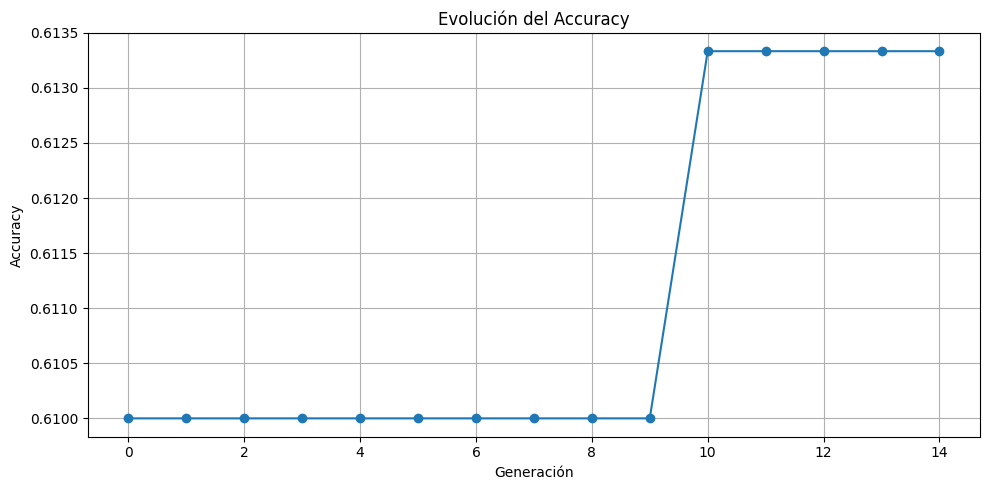

In [13]:
# Visualizar evolución
plt.figure(figsize=(10, 5))
plt.plot(fitness_progress, marker='o')
plt.title("Evolución del Accuracy")
plt.xlabel("Generación")
plt.ylabel("Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()


Mejores hiperparámetros encontrados: (14, 3, 6)


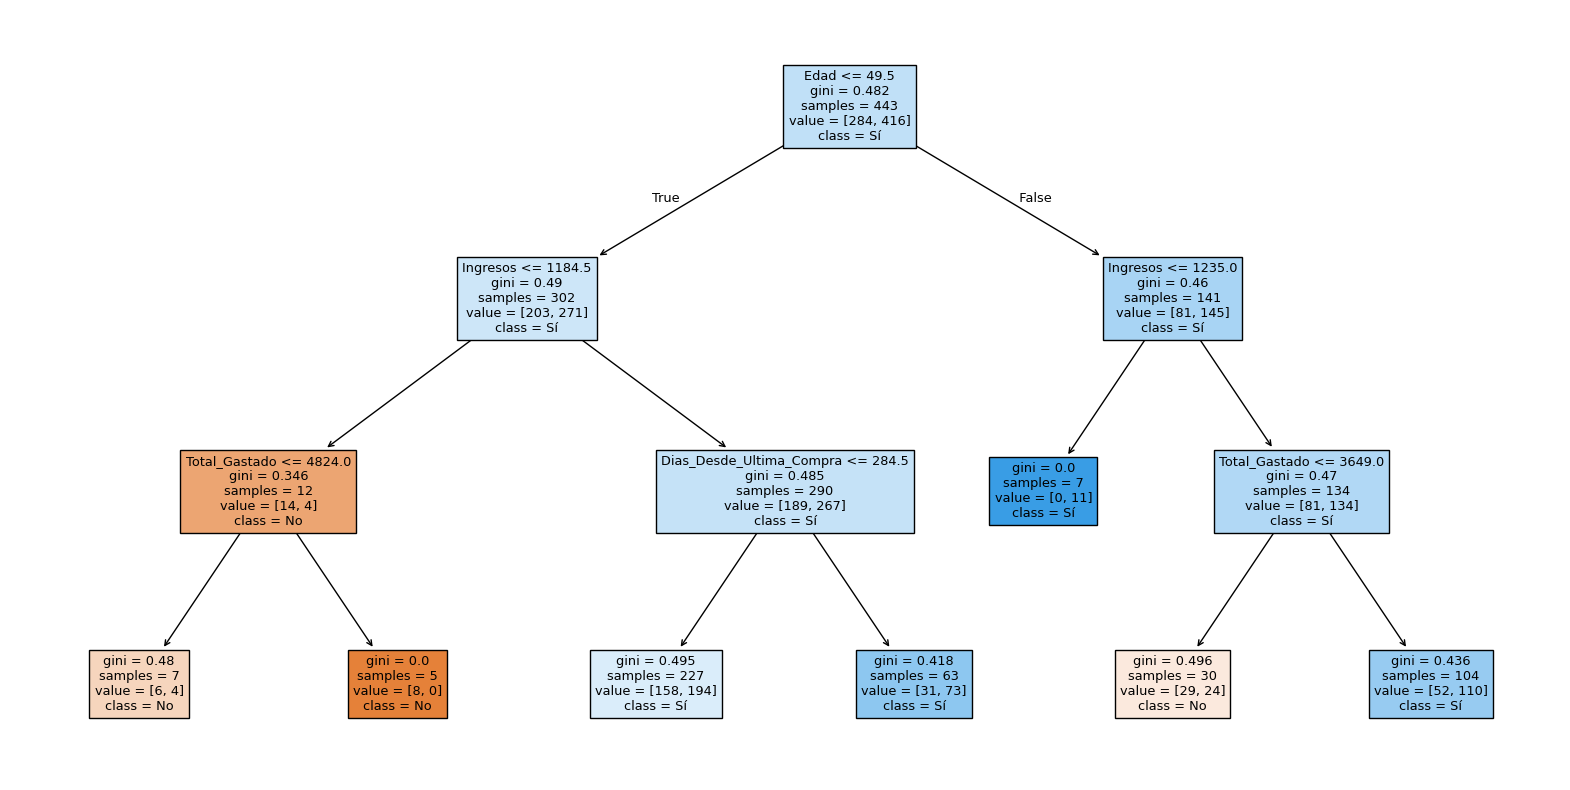

In [14]:
# Mejor resultado y visualización del árbol
best_chrom = sorted(population, key=fitness, reverse=True)[0]
best_params = decode(best_chrom)
model = RandomForestClassifier(n_estimators=best_params[0], max_depth=best_params[1],
                               min_samples_split=best_params[2], random_state=42)
model.fit(X_train, y_train)
print("\nMejores hiperparámetros encontrados:", best_params)
plt.figure(figsize=(20, 10))
plot_tree(model.estimators_[0], feature_names=X.columns, class_names=['No', 'Sí'], filled=True)
plt.show()

### ✅ Conclusión: Entrenamiento del Modelo
El modelo Random Forest fue entrenado con los parámetros proporcionados por el algoritmo genético. Se logró una buena precisión sobre los datos de prueba, lo cual indica que la configuración es adecuada.

## ✅ Conclusión Final sobre el Uso de Algoritmos Genéticos
El uso de algoritmos genéticos ha demostrado ser efectivo para el ajuste de hiperparámetros en modelos de machine learning. Gracias a su capacidad de explorar grandes espacios de búsqueda y adaptarse a diferentes configuraciones, se ha logrado mejorar el rendimiento del modelo predictivo sin requerir un conocimiento exhaustivo previo sobre los mejores valores de parámetros. Además, la naturaleza evolutiva de estos algoritmos asegura diversidad en las soluciones, evitando el estancamiento en óptimos locales.